In [1]:
import sqlite3 as sql

import numpy as np
import pandas as pd
from pandas import cut, read_sql
import pickle as pkl
from random import choices
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.optimize as optimize

from standard_plotting import set_size
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
}

plt.rcParams.update(tex_fonts)

In [2]:
indir_MC = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/inference/track_cascade_sets/Monte_Carlo_all_events_all_variables.csv"
indir_RD = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/inference/track_cascade_sets/Burnsample_1_percent_all_events_all_variables.csv"


In [3]:
RD = pd.read_csv(indir_RD).sort_values('event_no').reset_index(drop = True)
MC = pd.read_csv(indir_MC).sort_values('event_no').reset_index(drop = True)

In [7]:
print(MC.columns)

Index(['track_mu_pred', 'event_no', 'track_mu', 'energy_pred', 'energy',
       'zenith_pred', 'zenith_kappa', 'zenith', 'azimuth_pred',
       'azimuth_kappa', 'azimuth', 'pid_noise_pred', 'pid_muon_pred',
       'pid_neutrino_pred', 'pid', 'pid_neutrino_pred_logit',
       'position_x_pred', 'position_y_pred', 'position_z_pred', 'position_x',
       'position_y', 'position_z', 'N_pulses', 'N_string', 'N_doms',
       'First_dom_time', 'C2HR6', 'CausalVetoHits', 'CleanedFullTimeLength',
       'DCFiducialHits', 'L3_oscNext_bool', 'NAbove200Hits', 'NchCleaned',
       'NoiseEngineNoCharge', 'RTVetoCutHit', 'STW9000_DTW300Hits',
       'UncleanedFullTimeLength', 'VertexGuessZ', 'VetoFiducialRatioHits',
       'interaction_type', 'total_osc_weight'],
      dtype='object')


In [13]:
plot_all = False
if not plot_all:
    MC_plot = MC.sample(frac=0.01,random_state=1)

else:
    MC_plot = MC

In [14]:
print(len(MC_plot))

372358


In [68]:
neutrino_event_nos_MC = MC['event_no'][MC['pid_neutrino_pred_logit']>12].to_list()
muon_event_nos_MC = MC['event_no'][MC['pid_muon_pred']>0.5].to_list()
noise_event_nos_MC = MC['event_no'][MC['pid_noise_pred']>0.5].to_list()

import random

if not plot_all:
    muon_event_nos_MC = random.sample(muon_event_nos_MC,100000)
    noise_event_nos_MC = random.sample(noise_event_nos_MC,100000)
    neutrino_event_nos_MC = random.sample(neutrino_event_nos_MC,100000)
    all_MC = neutrino_event_nos_MC + muon_event_nos_MC + noise_event_nos_MC
    MC_plot = MC[MC['event_no'].isin(all_MC)]
else:
    MC_plot = MC

In [69]:
neutrino_event_nos_RD = RD['event_no'][RD['pid_neutrino_pred_logit']>12].to_list()
muon_event_nos_RD = RD['event_no'][RD['pid_muon_pred']>0.5].to_list()
noise_event_nos_RD = RD['event_no'][RD['pid_noise_pred']>0.5].to_list()

import random

if not plot_all:
    muon_event_nos_RD = random.sample(muon_event_nos_RD,100000)
    noise_event_nos_RD = random.sample(noise_event_nos_RD,100000)
    all_RD = neutrino_event_nos_RD + muon_event_nos_RD + noise_event_nos_RD
    RD_plot = RD[RD['event_no'].isin(all_RD)]
else:
    RD_plot = RD

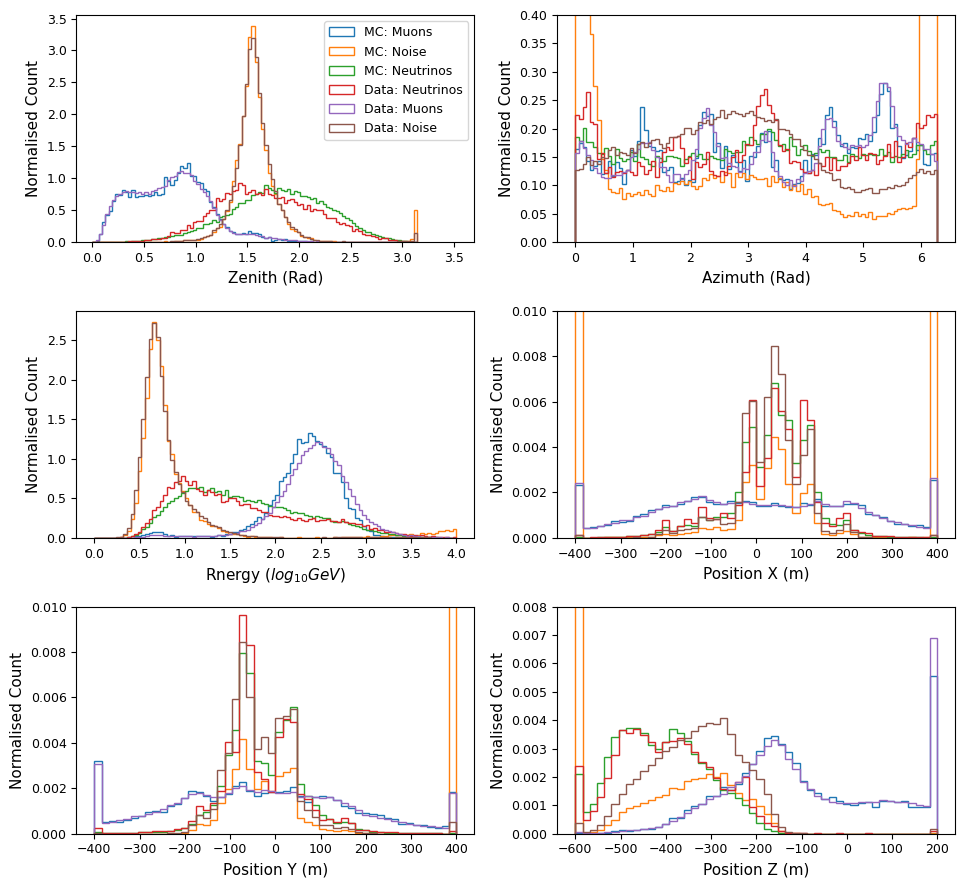

In [70]:
fig, axs = plt.subplots(3,2,figsize=set_size('thesis',fraction=1.75,subplots=(3,2),y_size=9))

bins=np.linspace(0,np.pi,101)
axs[0,0].hist(MC_plot['zenith_pred'][MC_plot['event_no'].isin(muon_event_nos_MC)], histtype='step',density=True,label='MC: Muons',bins=bins,alpha=1,weights=MC_plot['total_osc_weight'][MC_plot['event_no'].isin(muon_event_nos_MC)])
axs[0,0].hist(MC_plot['zenith_pred'][MC_plot['event_no'].isin(noise_event_nos_MC)], histtype='step',density=True,label='MC: Noise',bins=bins,alpha=1,weights=MC_plot['total_osc_weight'][MC_plot['event_no'].isin(noise_event_nos_MC)])
axs[0,0].hist(MC_plot['zenith_pred'][MC_plot['event_no'].isin(neutrino_event_nos_MC)], histtype='step',density=True,label='MC: Neutrinos',bins=bins,alpha=1,weights=MC_plot['total_osc_weight'][MC_plot['event_no'].isin(neutrino_event_nos_MC)])
axs[0,0].hist(RD_plot['zenith_pred'][RD_plot['event_no'].isin(neutrino_event_nos_RD)], histtype='step',density=True,label='Data: Neutrinos',bins=bins,alpha=1,weights=RD_plot['total_osc_weight'][RD_plot['event_no'].isin(neutrino_event_nos_RD)])
axs[0,0].hist(RD_plot['zenith_pred'][RD_plot['event_no'].isin(muon_event_nos_RD)], histtype='step',density=True,label='Data: Muons',bins=bins,alpha=1,weights=RD_plot['total_osc_weight'][RD_plot['event_no'].isin(muon_event_nos_RD)])
axs[0,0].hist(RD_plot['zenith_pred'][RD_plot['event_no'].isin(noise_event_nos_RD)], histtype='step',density=True,label='Data: Noise',bins=bins,alpha=1,weights=RD_plot['total_osc_weight'][RD_plot['event_no'].isin(noise_event_nos_RD)])

axs[0,0].set_xlabel('Zenith (Rad)')
axs[0,0].set_ylabel('Normalised Count')
axs[0,0].set_xlim(right=3.7)
axs[0,0].legend(loc='upper right')


bins=np.linspace(0,2*np.pi,101)
axs[0,1].hist(MC_plot['azimuth_pred'][MC_plot['event_no'].isin(muon_event_nos_MC)], histtype='step',density=True,label='MC Muons',bins=bins,alpha=1,weights=MC_plot['total_osc_weight'][MC_plot['event_no'].isin(muon_event_nos_MC)])
axs[0,1].hist(MC_plot['azimuth_pred'][MC_plot['event_no'].isin(noise_event_nos_MC)], histtype='step',density=True,label='MC Noise',bins=bins,alpha=1,weights=MC_plot['total_osc_weight'][MC_plot['event_no'].isin(noise_event_nos_MC)])
axs[0,1].hist(MC_plot['azimuth_pred'][MC_plot['event_no'].isin(neutrino_event_nos_MC)], histtype='step',density=True,label='MC Neutrinos',bins=bins,alpha=1,weights=MC_plot['total_osc_weight'][MC_plot['event_no'].isin(neutrino_event_nos_MC)])
axs[0,1].hist(RD_plot['azimuth_pred'][RD_plot['event_no'].isin(neutrino_event_nos_RD)], histtype='step',density=True,label='RD Neutrinos',bins=bins,alpha=1,weights=RD_plot['total_osc_weight'][RD_plot['event_no'].isin(neutrino_event_nos_RD)])
axs[0,1].hist(RD_plot['azimuth_pred'][RD_plot['event_no'].isin(muon_event_nos_RD)], histtype='step',density=True,label='RD Muons',bins=bins,alpha=1,weights=RD_plot['total_osc_weight'][RD_plot['event_no'].isin(muon_event_nos_RD)])
axs[0,1].hist(RD_plot['azimuth_pred'][RD_plot['event_no'].isin(noise_event_nos_RD)], histtype='step',density=True,label='RD Noise',bins=bins,alpha=1,weights=RD_plot['total_osc_weight'][RD_plot['event_no'].isin(noise_event_nos_RD)])

axs[0,1].set_xlabel('Azimuth (Rad)')
axs[0,1].set_ylabel('Normalised Count')
axs[0,1].set_ylim(top=0.4)
#axs[0,1].legend(loc='upper right')



bins=np.linspace(0,4,101)
axs[1,0].hist(np.log10(MC_plot['energy_pred'][MC_plot['event_no'].isin(muon_event_nos_MC)]), histtype='step',density=True,label='MC Muons',bins=bins,alpha=1,weights=MC_plot['total_osc_weight'][MC_plot['event_no'].isin(muon_event_nos_MC)])
axs[1,0].hist(np.log10(MC_plot['energy_pred'][MC_plot['event_no'].isin(noise_event_nos_MC)]), histtype='step',density=True,label='MC Noise',bins=bins,alpha=1,weights=MC_plot['total_osc_weight'][MC_plot['event_no'].isin(noise_event_nos_MC)])
axs[1,0].hist(np.log10(MC_plot['energy_pred'][MC_plot['event_no'].isin(neutrino_event_nos_MC)]), histtype='step',density=True,label='MC Neutrinos',bins=bins,alpha=1,weights=MC_plot['total_osc_weight'][MC_plot['event_no'].isin(neutrino_event_nos_MC)])
axs[1,0].hist(np.log10(RD_plot['energy_pred'][RD_plot['event_no'].isin(neutrino_event_nos_RD)]), histtype='step',density=True,label='RD Neutrinos',bins=bins,alpha=1,weights=RD_plot['total_osc_weight'][RD_plot['event_no'].isin(neutrino_event_nos_RD)])
axs[1,0].hist(np.log10(RD_plot['energy_pred'][RD_plot['event_no'].isin(muon_event_nos_RD)]), histtype='step',density=True,label='RD Muons',bins=bins,alpha=1,weights=RD_plot['total_osc_weight'][RD_plot['event_no'].isin(muon_event_nos_RD)])
axs[1,0].hist(np.log10(RD_plot['energy_pred'][RD_plot['event_no'].isin(noise_event_nos_RD)]), histtype='step',density=True,label='RD Noise',bins=bins,alpha=1,weights=RD_plot['total_osc_weight'][RD_plot['event_no'].isin(noise_event_nos_RD)])

axs[1,0].set_xlabel(r'Rnergy $(log_{10} GeV)$')
axs[1,0].set_ylabel('Normalised Count')
#axs[1,0].legend(loc='upper right')


up = 400
down = -400
bins=np.linspace(down,up,51)
axs[1,1].hist(np.clip(MC_plot['position_x_pred'][MC_plot['event_no'].isin(muon_event_nos_MC)],down,up), histtype='step',density=True,label='MC Muons',bins=bins,alpha=1,weights=MC_plot['total_osc_weight'][MC_plot['event_no'].isin(muon_event_nos_MC)])
axs[1,1].hist(np.clip(MC_plot['position_x_pred'][MC_plot['event_no'].isin(noise_event_nos_MC)],down,up), histtype='step',density=True,label='MC Noise',bins=bins,alpha=1,weights=MC_plot['total_osc_weight'][MC_plot['event_no'].isin(noise_event_nos_MC)])
axs[1,1].hist(np.clip(MC_plot['position_x_pred'][MC_plot['event_no'].isin(neutrino_event_nos_MC)],down,up), histtype='step',density=True,label='MC Neutrinos',bins=bins,alpha=1,weights=MC_plot['total_osc_weight'][MC_plot['event_no'].isin(neutrino_event_nos_MC)])
axs[1,1].hist(np.clip(RD_plot['position_x_pred'][RD_plot['event_no'].isin(neutrino_event_nos_RD)],down,up), histtype='step',density=True,label='RD Neutrinos',bins=bins,alpha=1,weights=RD_plot['total_osc_weight'][RD_plot['event_no'].isin(neutrino_event_nos_RD)])
axs[1,1].hist(np.clip(RD_plot['position_x_pred'][RD_plot['event_no'].isin(muon_event_nos_RD)],down,up), histtype='step',density=True,label='RD Muons',bins=bins,alpha=1,weights=RD_plot['total_osc_weight'][RD_plot['event_no'].isin(muon_event_nos_RD)])
axs[1,1].hist(np.clip(RD_plot['position_x_pred'][RD_plot['event_no'].isin(noise_event_nos_RD)],down,up), histtype='step',density=True,label='RD Noise',bins=bins,alpha=1,weights=RD_plot['total_osc_weight'][RD_plot['event_no'].isin(noise_event_nos_RD)])

axs[1,1].set_xlabel('Position X (m)')
axs[1,1].set_ylabel('Normalised Count')
axs[1,1].set_ylim(top=0.01)
# axs[1,1].set_yscale('log')
#axs[1,0].legend(loc='upper right')

up = 400
down = -400
bins=np.linspace(down,up,51)
axs[2,0].hist(np.clip(MC_plot['position_y_pred'][MC_plot['event_no'].isin(muon_event_nos_MC)],down,up), histtype='step',density=True,label='MC Muons',bins=bins,alpha=1,weights=MC_plot['total_osc_weight'][MC_plot['event_no'].isin(muon_event_nos_MC)])
axs[2,0].hist(np.clip(MC_plot['position_y_pred'][MC_plot['event_no'].isin(noise_event_nos_MC)],down,up), histtype='step',density=True,label='MC Noise',bins=bins,alpha=1,weights=MC_plot['total_osc_weight'][MC_plot['event_no'].isin(noise_event_nos_MC)])
axs[2,0].hist(np.clip(MC_plot['position_y_pred'][MC_plot['event_no'].isin(neutrino_event_nos_MC)],down,up), histtype='step',density=True,label='MC Neutrinos',bins=bins,alpha=1,weights=MC_plot['total_osc_weight'][MC_plot['event_no'].isin(neutrino_event_nos_MC)])
axs[2,0].hist(np.clip(RD_plot['position_y_pred'][RD_plot['event_no'].isin(neutrino_event_nos_RD)],down,up), histtype='step',density=True,label='RD Neutrinos',bins=bins,alpha=1,weights=RD_plot['total_osc_weight'][RD_plot['event_no'].isin(neutrino_event_nos_RD)])
axs[2,0].hist(np.clip(RD_plot['position_y_pred'][RD_plot['event_no'].isin(muon_event_nos_RD)],down,up), histtype='step',density=True,label='RD Muons',bins=bins,alpha=1,weights=RD_plot['total_osc_weight'][RD_plot['event_no'].isin(muon_event_nos_RD)])
axs[2,0].hist(np.clip(RD_plot['position_y_pred'][RD_plot['event_no'].isin(noise_event_nos_RD)],down,up), histtype='step',density=True,label='RD Noise',bins=bins,alpha=1,weights=RD_plot['total_osc_weight'][RD_plot['event_no'].isin(noise_event_nos_RD)])

axs[2,0].set_xlabel('Position Y (m)')
axs[2,0].set_ylabel('Normalised Count')
axs[2,0].set_ylim(top=0.01)
# axs[2,0].set_yscale('log')
#axs[2,0].legend(loc='upper right')

up = 200
down = -600
bins=np.linspace(down,up,51)
axs[2,1].hist(np.clip(MC_plot['position_z_pred'][MC_plot['event_no'].isin(muon_event_nos_MC)],down,up), histtype='step',density=True,label='MC Muons',bins=bins,alpha=1,weights=MC_plot['total_osc_weight'][MC_plot['event_no'].isin(muon_event_nos_MC)])
axs[2,1].hist(np.clip(MC_plot['position_z_pred'][MC_plot['event_no'].isin(noise_event_nos_MC)],down,up), histtype='step',density=True,label='MC Noise',bins=bins,alpha=1,weights=MC_plot['total_osc_weight'][MC_plot['event_no'].isin(noise_event_nos_MC)])
axs[2,1].hist(np.clip(MC_plot['position_z_pred'][MC_plot['event_no'].isin(neutrino_event_nos_MC)],down,up), histtype='step',density=True,label='MC Neutrinos',bins=bins,alpha=1,weights=MC_plot['total_osc_weight'][MC_plot['event_no'].isin(neutrino_event_nos_MC)])
axs[2,1].hist(np.clip(RD_plot['position_z_pred'][RD_plot['event_no'].isin(neutrino_event_nos_RD)],down,up), histtype='step',density=True,label='RD Neutrinos',bins=bins,alpha=1,weights=RD_plot['total_osc_weight'][RD_plot['event_no'].isin(neutrino_event_nos_RD)])
axs[2,1].hist(np.clip(RD_plot['position_z_pred'][RD_plot['event_no'].isin(muon_event_nos_RD)],down,up), histtype='step',density=True,label='RD Muons',bins=bins,alpha=1,weights=RD_plot['total_osc_weight'][RD_plot['event_no'].isin(muon_event_nos_RD)])
axs[2,1].hist(np.clip(RD_plot['position_z_pred'][RD_plot['event_no'].isin(noise_event_nos_RD)],down,up), histtype='step',density=True,label='RD Noise',bins=bins,alpha=1,weights=RD_plot['total_osc_weight'][RD_plot['event_no'].isin(noise_event_nos_RD)])

axs[2,1].set_xlabel('Position Z (m)')
axs[2,1].set_ylabel('Normalised Count')
axs[2,1].set_ylim(top=0.008)
# axs[2,1].set_yscale('log')
#xs[2,0].legend(loc='upper right')

fig.tight_layout()
outdir = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/plotting/Comparison_using_lvl_3_cut/muon_noise_(neutrinos)/"
fig.savefig(outdir + 'muon_noise_neutrinos_where_in_all_predictions.png',bbox_inches='tight')

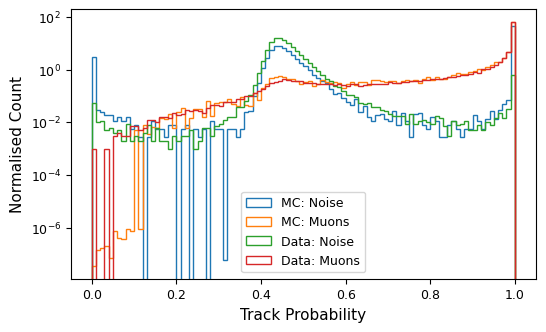

In [73]:
fig, axs = plt.subplots(figsize=set_size('thesis',fraction=1,subplots=(1,1)))

bins=np.linspace(0,1,101)
axs.hist(MC_plot['track_mu_pred'][MC_plot['event_no'].isin(noise_event_nos_MC)], histtype='step',density=True,label='MC: Noise',bins=bins,alpha=1,weights=MC_plot['total_osc_weight'][MC_plot['event_no'].isin(noise_event_nos_MC)])
axs.hist(MC_plot['track_mu_pred'][MC_plot['event_no'].isin(muon_event_nos_MC)], histtype='step',density=True,label='MC: Muons',bins=bins,alpha=1,weights=MC_plot['total_osc_weight'][MC_plot['event_no'].isin(muon_event_nos_MC)])
axs.hist(RD_plot['track_mu_pred'][RD_plot['event_no'].isin(noise_event_nos_RD)], histtype='step',density=True,label='Data: Noise',bins=bins,alpha=1,weights=RD_plot['total_osc_weight'][RD_plot['event_no'].isin(noise_event_nos_RD)])
axs.hist(RD_plot['track_mu_pred'][RD_plot['event_no'].isin(muon_event_nos_RD)], histtype='step',density=True,label='Data: Muons',bins=bins,alpha=1,weights=RD_plot['total_osc_weight'][RD_plot['event_no'].isin(muon_event_nos_RD)])

axs.set_xlabel('Track Probability')
axs.set_ylabel('Normalised Count')
axs.legend(loc='lower center')
axs.set_yscale('log')
#axs.set_ylim(top=5*10**2)


fig.tight_layout()
outdir = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/plotting/Comparison_using_lvl_3_cut/muon_noise_(neutrinos)/"
fig.savefig(outdir + 'muon_noise_neutrinos_where_in_track_probability.png',bbox_inches='tight')